In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from textblob import TextBlob
import spacy

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Dhruv
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Dhruv
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Dhruv
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# reading the filre
df = pd.read_csv('cyberbullying/youtube_parsed_dataset.csv')

In [6]:
df.head()

,index,UserIndex,Text,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,oh_label
0,0,X1,Does N.e.bodyelse Hear her Crazy ass Screamin ...,10,1,3,3,0,15,0
1,1,X2,There are so many things that are incorrect wi...,3,0,6,5,0,31,0
2,2,X3,3:26 hahah my boyfriend showed this song to me...,7,0,3,5,0,43,1
3,3,X2218,dick beyonce fuck y a ass hole you are truely ...,34,0,3,5,0,44,1
4,4,X5,DongHaeTaemin and Kai ;A; luhansehun and bacon...,11,173,5,5,0,21,0


In [7]:
df = df.drop(['UserIndex', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)



In [9]:
df.columns

Index(['Text', 'Number of Comments', 'Number of Subscribers',
       'Membership Duration', 'Number of Uploads', 'Profanity in UserID',
       'Age', 'Label'],
      dtype='object')

In [10]:
df.describe()

,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,Label
count,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000
mean,15.452367,304.318995,3.714781,10.288395,0.113164,24.879042,0.120381
std,10.862517,15520.532319,1.392837,28.646525,0.316839,13.286361,0.325454
min,1.000000,0.000000,2.000000,1.000000,0.000000,13.000000,0.000000
25%,6.000000,0.000000,3.000000,5.000000,0.000000,18.000000,0.000000
50%,14.000000,2.000000,3.000000,5.000000,0.000000,21.000000,0.000000
75%,23.000000,7.000000,4.000000,5.000000,0.000000,27.000000,0.000000
max,50.000000,912377.000000,9.000000,820.000000,1.000000,112.000000,1.000000


In [11]:
unique_values_df = df.apply(pd.Series.unique)
print(unique_values_df)

Text                     [Does N.e.bodyelse Hear her Crazy ass Screamin...
Number of Comments       [10, 3, 7, 34, 11, 12, 1, 19, 8, 6, 20, 16, 22...
Number of Subscribers    [1, 0, 173, 76, 7, 25, 171, 5, 10, 4, 2, 28, 1...
Membership Duration                               [3, 6, 5, 2, 4, 7, 8, 9]
Number of Uploads        [3, 5, 1, 2, 34, 11, 4, 18, 8, 159, 6, 23, 191...
Profanity in UserID                                                 [0, 1]
Age                      [15, 31, 43, 44, 21, 27, 23, 56, 20, 26, 22, 3...
Label                                                               [0, 1]
dtype: object


In [12]:
missing = df.isnull().sum()
print("missing values: ", missing)

missing values:  Text                     0
Number of Comments       0
Number of Subscribers    0
Membership Duration      0
Number of Uploads        0
Profanity in UserID      0
Age                      0
Label                    0
dtype: int64


#### There are no missing values 


In [13]:

stop_words = set(stopwords.words('english'))


In [14]:

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens


In [15]:
df['processed_text'] = df['Text'].apply(preprocess_text)


In [16]:
all_tokens = [token for sublist in df['processed_text'] for token in sublist]


In [17]:
##Calculate word frequency
word_freq = pd.Series(all_tokens).value_counts().sort_values(ascending=False)

In [18]:
print(word_freq.head(20))

like      5151
love      3162
lol       2463
one       2340
u         2328
get       2264
people    2100
song      2087
would     2054
video     2013
good      1981
know      1858
really    1751
think     1630
3         1463
im        1429
fuck      1328
go        1316
make      1310
got       1307
Name: count, dtype: int64


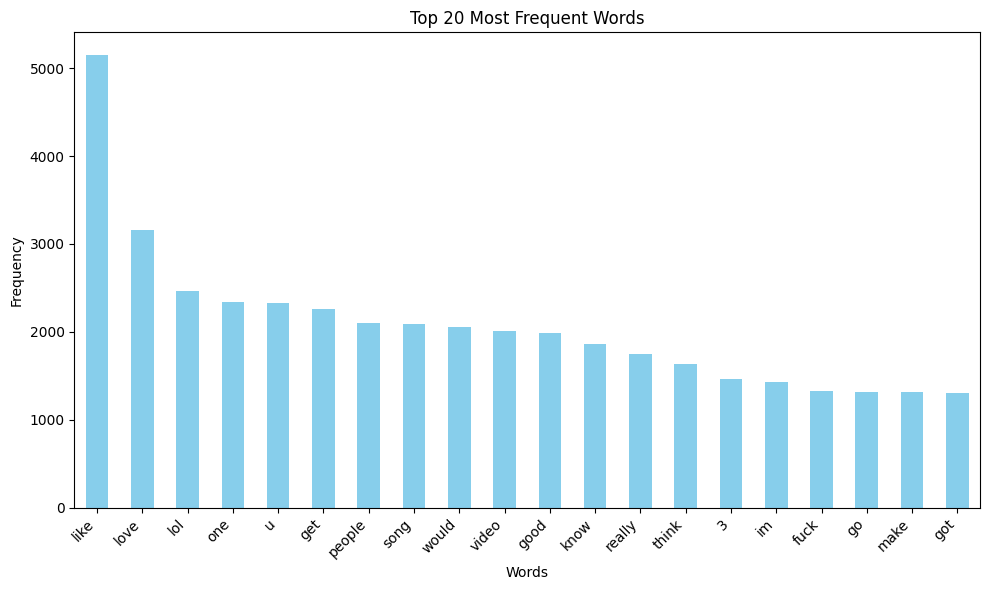

In [19]:
# Visualization of Word Frequency
plt.figure(figsize=(10, 6))
word_freq.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# Topic Modeling using Latent Dirichlet Allocation (LDA)
# Convert text data to document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['Text'])



In [21]:
# Initialize LDA model
num_topics = 5  # Number of topics to extract
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
# Fit LDA model to the document-term matrix
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [22]:
# Function to display topics and associated words
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [23]:
# Display the topics and associated words
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()  # Retrieve feature names
print(f"\nTop {num_top_words} words for each topic:")
display_topics(lda_model, feature_names, num_top_words)


Top 10 words for each topic:
Topic 1:
love ur song good video amazing really ich die voice
Topic 2:
like just love lol song video know good im really
Topic 3:
que la en te el si es para se est
Topic 4:
people just like don know think god good way make
Topic 5:
like just watch make good fuck don video fucking shit


In [24]:

# Function to perform sentiment analysis on text data
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Get the sentiment polarity (-1 to 1)
    sentiment_polarity = analysis.sentiment.polarity
    # Return the sentiment polarity
    return sentiment_polarity

# Apply sentiment analysis to each text entry in the DataFrame
df['Sentiment_Polarity'] = df['Text'].apply(analyze_sentiment)

# Classify sentiment labels based on polarity values
def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [25]:

# Apply sentiment label classification to each sentiment polarity
df['Sentiment_Label'] = df['Sentiment_Polarity'].apply(classify_sentiment)

# Display the DataFrame with sentiment analysis results
print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label']])



                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  
0           Negative  
1    

#### Finding the number of positive negative and neutral sentiments

In [26]:
# Count the occurrences of each sentiment label
sentiment_counts = df['Sentiment_Label'].value_counts()

# Print the counts of positive, neutral, and negative sentiments
print("Number of Positive Sentiments:", sentiment_counts.get('Positive', 0))
print("Number of Neutral Sentiments:", sentiment_counts.get('Neutral', 0))
print("Number of Negative Sentiments:", sentiment_counts.get('Negative', 0))

Number of Positive Sentiments: 2808
Number of Neutral Sentiments: 166
Number of Negative Sentiments: 490


In [27]:


# Classify sentiment labels based on polarity values
def classify_sentiment(polarity):
    if polarity > 0:
        return 0  # Positive or Neutral sentiment
    else:
        return 1  # Negative sentiment

# Apply sentiment label classification to each sentiment polarity
df['Sentiment'] = df['Sentiment_Polarity'].apply(classify_sentiment)

# Display the DataFrame with sentiment analysis results and the new sentiment column
print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label', 'Sentiment']])

# Count the occurrences of each sentiment label
sentiment_counts = df['Sentiment'].value_counts()

# Print the counts of positive and negative sentiments
print("Number of Positive or Neutral Sentiments:", sentiment_counts.get(0, 0))
print("Number of Negative Sentiments:", sentiment_counts.get(1, 0))


                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  Sentiment  
0           Negat

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'dataset' is your DataFrame and 'Text' is the column containing text data
text_data = df['Text']

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert TF-IDF matrix to a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())




In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Preprocess the text data
# Assuming 'Text' is the column name containing text data
text_data = df['Text']

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the text data to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Apply NMF to discover topics
num_topics = 5  # Define the number of topics
nmf_model = NMF(n_components=num_topics, random_state=42)

# Fit NMF model to the TF-IDF matrix
nmf_model.fit(tfidf_matrix)

# Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10  # Number of top words to display for each topic
print(f"\nTop {num_top_words} words for each topic:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), num_top_words)


Top 10 words for each topic:
Topic 1:
like just people don know video think fucking fuck really
Topic 2:
love song amazing omg voice cute good great beautiful really
Topic 3:
que la el es en se lo por los si
Topic 4:
lol ur xd im lmao dont like funny omg got
Topic 5:
ich ist das und die du der nicht ein es


In [30]:
# Display topics and identify relevant topics related to criminal behavior
num_top_words = 10  # Number of top words to display for each topic

print("Identifying topics related to criminal behavior:")
for topic_idx, topic in enumerate(nmf_model.components_):
    topic_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"\nTopic {topic_idx + 1}:")
    print(" ".join(topic_words))

# Identify relevant topics related to criminal behavior based on the context of the words
relevant_topics = [0, 2]  # Assuming topics 0 and 2 are related to criminal behavior

# Inspect top words associated with relevant topics
print("\nTop words related to criminal behavior:")
for topic_idx in relevant_topics:
    topic_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in nmf_model.components_[topic_idx].argsort()[:-num_top_words - 1:-1]]
    print(f"\nTopic {topic_idx + 1}:")
    print(" ".join(topic_words))

Identifying topics related to criminal behavior:

Topic 1:
like just people don know video think fucking fuck really

Topic 2:
love song amazing omg voice cute good great beautiful really

Topic 3:
que la el es en se lo por los si

Topic 4:
lol ur xd im lmao dont like funny omg got

Topic 5:
ich ist das und die du der nicht ein es

Top words related to criminal behavior:

Topic 1:
like just people don know video think fucking fuck really

Topic 3:
que la el es en se lo por los si


In [31]:
# Define a list of cursed words
cursed_words = ['fuck', 'shit', 'asshole', 'bitch', 'damn', 'crap', 'hell', 'bastard', 'piss', 'dick','pussy', 'mf','mother fucker', 'behenchod']

# Function to count cursed words in a text
def count_cursed_words(text):
    count = 0
    for word in text.split():
        if word.lower() in cursed_words:
            count += 1
    return count

# Add a new column for the number of cursed words
df['No_of_Cursed_Words'] = df['Text'].apply(count_cursed_words)




In [32]:
df['No_of_Cursed_Words'].value_counts()

No_of_Cursed_Words
0     2056
1      604
2      295
3      173
4      111
5       93
6       41
7       27
8       20
9       15
10       7
11       6
13       4
14       3
12       3
21       1
22       1
25       1
18       1
27       1
17       1
Name: count, dtype: int64

In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'dataset' is your DataFrame and 'Text' is the column containing text data
text_data = df['Text']

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF DataFrame with the original dataset
dataset_with_tfidf = pd.concat([df, tfidf_df], axis=1)

# Display the dataset with TF-IDF scores
print(dataset_with_tfidf.head())


                                                Text  Number of Comments  \
0  Does N.e.bodyelse Hear her Crazy ass Screamin ...                  10   
1  There are so many things that are incorrect wi...                   3   
2  3:26 hahah my boyfriend showed this song to me...                   7   
3  dick beyonce fuck y a ass hole you are truely ...                  34   
4  DongHaeTaemin and Kai ;A; luhansehun and bacon...                  11   

   Number of Subscribers  Membership Duration  Number of Uploads  \
0                      1                    3                  3   
1                      0                    6                  5   
2                      0                    3                  5   
3                      0                    3                  5   
4                    173                    5                  5   

   Profanity in UserID  Age  Label  \
0                    0   15      0   
1                    0   31      0   
2                   

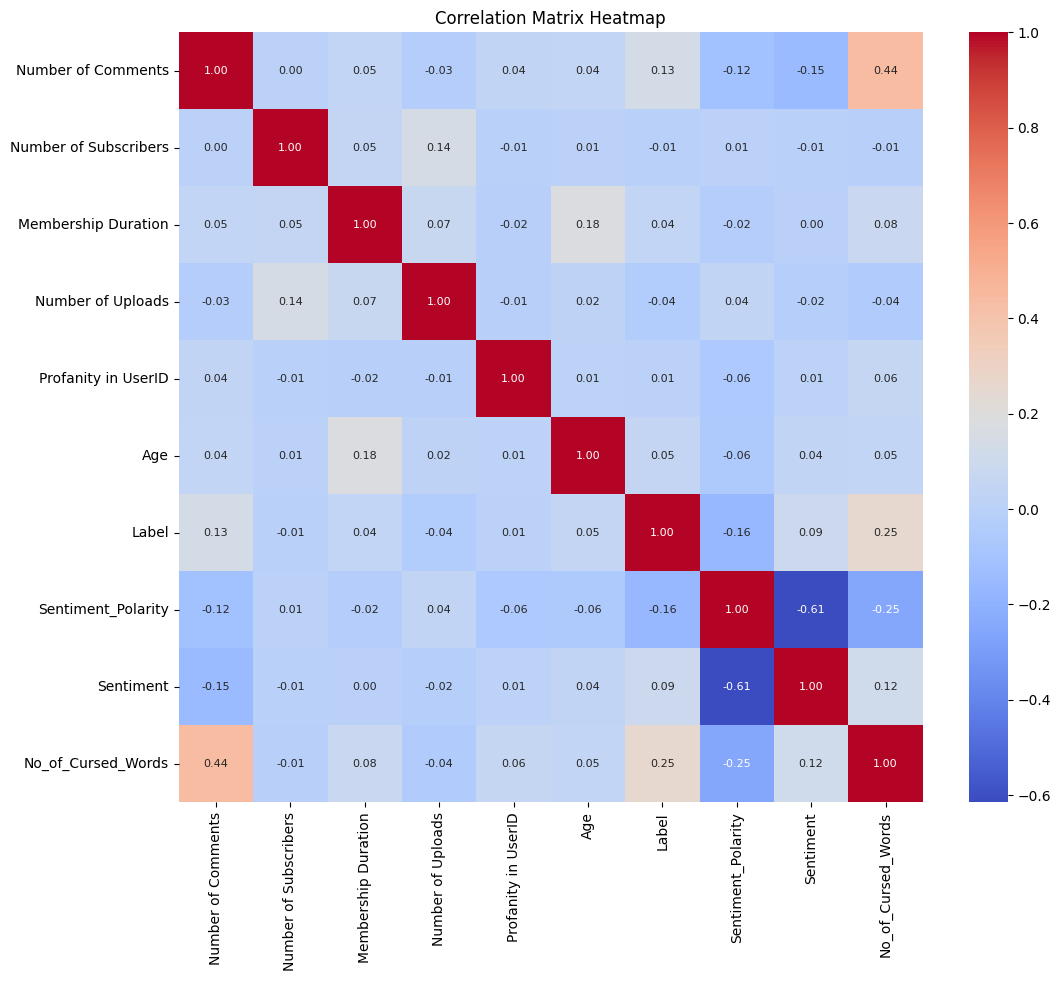

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove columns containing non-numeric values
numeric_df = df.select_dtypes(include='number')

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix Heatmap')
plt.show()


In [35]:
df.columns

Index(['Text', 'Number of Comments', 'Number of Subscribers',
       'Membership Duration', 'Number of Uploads', 'Profanity in UserID',
       'Age', 'Label', 'processed_text', 'Sentiment_Polarity',
       'Sentiment_Label', 'Sentiment', 'No_of_Cursed_Words'],
      dtype='object')

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Profanity in UserID', hue='Sentiment', data=dataset)

# Add text annotations above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution of Profanity in User ID by Sentiment')
plt.xlabel('Profanity in User ID')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')
plt.show()


NameError: name 'dataset' is not defined

<Figure size 800x600 with 0 Axes>

In [40]:
df.columns

Index(['Text', 'Number of Comments', 'Number of Subscribers',
       'Membership Duration', 'Number of Uploads', 'Profanity in UserID',
       'Age', 'Label', 'processed_text', 'Sentiment_Polarity',
       'Sentiment_Label', 'Sentiment', 'No_of_Cursed_Words'],
      dtype='object')

In [41]:
# Get the data types of each column in the dataset
column_data_types = df.dtypes

# Identify numerical columns (those with numeric data types)
numerical_columns = column_data_types[column_data_types != 'object'].index.tolist()

# Remove the target variable ('oh_label') from numerical_columns if needed
if 'oh_label' in numerical_columns:
    numerical_columns.remove('oh_label')

print("Numerical columns:", numerical_columns)


Numerical columns: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Label', 'Sentiment_Polarity', 'Sentiment', 'No_of_Cursed_Words']


In [42]:
# Step 2: Oversample the data using RandomOverSampler to reduce imbalance between Labels (Bullying and non bullying)
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)


NameError: name 'RandomOverSampler' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Assuming 'oh_label' is the target variable and 'Profanity in User ID' is a feature
X = df['processed_text']
y = df['Label']

